# Gesture Recognition
This group project is done by Alok Narayan and Nandha Kishore. We are going to build a 3D Conv model that will be able to predict the 5 gestures correctly. We import the following libraries to get started.

In [1]:
# Importing the required libraries

import numpy as np
from imageio import imread
from skimage.transform import resize
import os
import datetime

import warnings
warnings.filterwarnings("ignore")

import abc
from sys import getsizeof

import cv2
import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
np.random.seed(30)
import random as rn
rn.seed(30)
from keras import backend as K
import tensorflow as tf
tf.random.set_seed(30)

In [3]:
# TO run in Colab
!gdown --id 1ehyrYBQ5rbQQe6yL4XbLWe3FMvuVUGiL
!unzip Project_data.zip

Streaming output truncated to the last 5000 lines.
 extracting: Project_data/train/WIN_20180926_17_34_37_Pro_Stop_new/WIN_20180926_17_34_37_Pro_00050.png  
 extracting: Project_data/train/WIN_20180926_17_34_37_Pro_Stop_new/WIN_20180926_17_34_37_Pro_00052.png  
 extracting: Project_data/train/WIN_20180926_17_34_37_Pro_Stop_new/WIN_20180926_17_34_37_Pro_00054.png  
 extracting: Project_data/train/WIN_20180926_17_34_37_Pro_Stop_new/WIN_20180926_17_34_37_Pro_00056.png  
 extracting: Project_data/train/WIN_20180926_17_34_37_Pro_Stop_new/WIN_20180926_17_34_37_Pro_00058.png  
 extracting: Project_data/train/WIN_20180926_17_34_37_Pro_Stop_new/WIN_20180926_17_34_37_Pro_00060.png  
 extracting: Project_data/train/WIN_20180926_17_34_37_Pro_Stop_new/WIN_20180926_17_34_37_Pro_00062.png  
   creating: Project_data/train/WIN_20180926_17_35_12_Pro_Thumbs_Down_new/
 extracting: Project_data/train/WIN_20180926_17_35_12_Pro_Thumbs_Down_new/WIN_20180926_17_35_12_Pro_00001.png  
 extracting: Project_data/t

In [4]:
import tensorflow as tf
from keras.models import Sequential, Model
from keras.layers import Dense, GRU, Flatten, TimeDistributed, Flatten, BatchNormalization, Activation
from keras.layers.convolutional import Conv3D, MaxPooling3D, Conv2D, MaxPooling2D
from keras.layers import LSTM
from keras.callbacks import ModelCheckpoint, ReduceLROnPlateau
from keras import optimizers
from keras.layers import Dropout

In [5]:
project_folder='/content/Project_data/'

In [6]:
# Plotting losses and accuarcies
def plot(history):
    fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(15,4))
    axes[0].plot(history.history['loss'])   
    axes[0].plot(history.history['val_loss'])
    axes[0].legend(['loss','val_loss'])

    axes[1].plot(history.history['categorical_accuracy'])   
    axes[1].plot(history.history['val_categorical_accuracy'])
    axes[1].legend(['categorical_accuracy','val_categorical_accuracy'])

## Generator
This is one of the most important part of the code. The overall structure of the generator has been given. In the generator, you are going to preprocess the images as you have images of 2 different dimensions as well as create a batch of video frames. You have to experiment with `img_idx`, `y`,`z` and normalization such that you get high accuracy.

In [7]:
class GenModel(metaclass= abc.ABCMeta):
    
    def initialize_path(self,project_folder):
        self.train_doc = np.random.permutation(open(project_folder + '/' + 'train.csv').readlines())
        self.val_doc = np.random.permutation(open(project_folder + '/' + 'val.csv').readlines())
        self.train_path = project_folder + '/' + 'train'
        self.val_path =  project_folder + '/' + 'val'
        self.num_train_sequences = len(self.train_doc)
        self.num_val_sequences = len(self.val_doc)
        
    def initialize_image_properties(self,image_height=100,image_width=100):
        self.image_height=image_height
        self.image_width=image_width
        self.channels=3
        self.num_classes=5
        self.total_frames=30
          
    def initialize_hyperparams(self,frames_to_sample=30,batch_size=20,num_epochs=20):
        self.frames_to_sample=frames_to_sample
        self.batch_size=batch_size
        self.num_epochs=num_epochs
        
    def generator(self,source_path, folder_list, augment=False):
        img_idx = np.round(np.linspace(0,self.total_frames-1,self.frames_to_sample)).astype(int)
        batch_size=self.batch_size
        while True:
            t = np.random.permutation(folder_list)
            num_batches = len(t)//batch_size
        
            for batch in range(num_batches): 
                batch_data, batch_labels= self.one_batch_data(source_path,t,batch,batch_size,img_idx,augment)
                yield batch_data, batch_labels 

            remaining_seq=len(t)%batch_size
        
            if (remaining_seq != 0):
                batch_data, batch_labels= self.one_batch_data(source_path,t,num_batches,batch_size,img_idx,augment,remaining_seq)
                yield batch_data, batch_labels 
        
    
    def one_batch_data(self,source_path,t,batch,batch_size,img_idx,augment,remaining_seq=0):
    
        seq_len = remaining_seq if remaining_seq else batch_size
    
        batch_data = np.zeros((seq_len,len(img_idx),self.image_height,self.image_width,self.channels)) 
        batch_labels = np.zeros((seq_len,self.num_classes)) 
    
        if (augment): batch_data_aug = np.zeros((seq_len,len(img_idx),self.image_height,self.image_width,self.channels))

        
        for folder in range(seq_len): 
            imgs = os.listdir(source_path+'/'+ t[folder + (batch*batch_size)].split(';')[0]) 
            for idx,item in enumerate(img_idx): 
                image = imread(source_path+'/'+ t[folder + (batch*batch_size)].strip().split(';')[0]+'/'+imgs[item]).astype(np.float32)          
                
                if image.shape[1] > image.shape[0]:
                        diff_px = image.shape[1] - image.shape[0]
                        crop_start = diff_px//2
                        crop_end = crop_start + image.shape[0]
                        image = image[:, crop_start:crop_end]
                elif image.shape[0] > image.shape[1]:
                        diff_px = image.shape[0] - image.shape[1]
                        crop_start = diff_px//2
                        crop_end = crop_start + image.shape[1]
                        image = image[:, crop_start:crop_end]
                
                image_resized=resize(image,(self.image_height,self.image_width,3))
            

                batch_data[folder,idx,:,:,0] = (image_resized[:,:,0])/255
                batch_data[folder,idx,:,:,1] = (image_resized[:,:,1])/255
                batch_data[folder,idx,:,:,2] = (image_resized[:,:,2])/255
            
                if (augment):
                    shifted = cv2.warpAffine(image, 
                                             np.float32([[1, 0, np.random.randint(-30,30)],[0, 1, np.random.randint(-30,30)]]), 
                                            (image.shape[1], image.shape[0]))
                    
                    gray = cv2.cvtColor(shifted,cv2.COLOR_BGR2GRAY)

                    x0, y0 = np.argwhere(gray > 0).min(axis=0)
                    x1, y1 = np.argwhere(gray > 0).max(axis=0) 
                    
                    cropped=shifted[x0:x1,y0:y1,:]
                    
                    image_resized=resize(cropped,(self.image_height,self.image_width,3))
                    
                    #shifted = cv2.warpAffine(image_resized, 
                    #                        np.float32([[1, 0, np.random.randint(-3,3)],[0, 1, np.random.randint(-3,3)]]), 
                    #                        (image_resized.shape[1], image_resized.shape[0]))
            
                    batch_data_aug[folder,idx,:,:,0] = (image_resized[:,:,0])/255
                    batch_data_aug[folder,idx,:,:,1] = (image_resized[:,:,1])/255
                    batch_data_aug[folder,idx,:,:,2] = (image_resized[:,:,2])/255
                
            
            batch_labels[folder, int(t[folder + (batch*batch_size)].strip().split(';')[2])] = 1
            
    
        if (augment):
            batch_data=np.concatenate([batch_data,batch_data_aug])
            batch_labels=np.concatenate([batch_labels,batch_labels])

        
        return(batch_data,batch_labels)
    
    
    def train_model(self, model, augment_data=False):
        train_generator = self.generator(self.train_path, self.train_doc,augment=augment_data)
        val_generator = self.generator(self.val_path, self.val_doc)

        model_name = 'model_init' + '_' + str(datetime.datetime.now()).replace(' ','').replace(':','_') + '/'
    
        if not os.path.exists(model_name):
            os.mkdir(model_name)
        
        filepath = model_name + 'model-{epoch:05d}-{loss:.5f}-{categorical_accuracy:.5f}-{val_loss:.5f}-{val_categorical_accuracy:.5f}.h5'

        checkpoint = ModelCheckpoint(filepath, monitor='val_loss', verbose=1, save_best_only=False, save_weights_only=False, mode='auto', period=1)
        LR = ReduceLROnPlateau(monitor='val_loss', factor=0.2, verbose=1, patience=4)
        callbacks_list = [checkpoint, LR]

        if (self.num_train_sequences%self.batch_size) == 0:
            steps_per_epoch = int(self.num_train_sequences/self.batch_size)
        else:
            steps_per_epoch = (self.num_train_sequences//self.batch_size) + 1

        if (self.num_val_sequences%self.batch_size) == 0:
            validation_steps = int(self.num_val_sequences/self.batch_size)
        else:
            validation_steps = (self.num_val_sequences//self.batch_size) + 1
    
        history=model.fit_generator(train_generator, steps_per_epoch=steps_per_epoch, epochs=self.num_epochs, verbose=1, 
                            callbacks=callbacks_list, validation_data=val_generator, 
                            validation_steps=validation_steps, class_weight=None, workers=1, initial_epoch=0)
        return history

        
    @abc.abstractmethod
    def define_model(self):
        pass

## Some Data Analysis

In [ ]:
class sampleModel(GenModel):
    def define_model(self):
        pass

In [ ]:
sample= sampleModel()
sample.initialize_path(project_folder)
sample.initialize_image_properties()

In [ ]:
print('# training sequences =', sample.num_train_sequences)
print('# validation sequences =', sample.num_val_sequences)

# training sequences = 663
# validation sequences = 100


In [ ]:
sample_batch_data, sample_batch_labels = next(sample.generator(sample.train_path, sample.train_doc))
sample_val_batch_data, sample_val_batch_labels = next(sample.generator(sample.val_path, sample.val_doc))

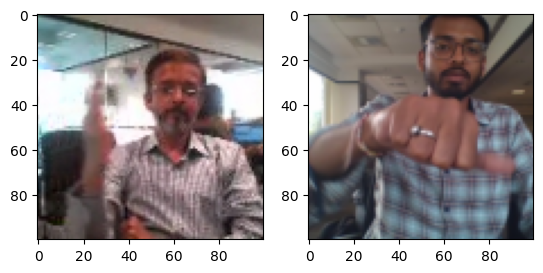

In [ ]:
# plot generated sample images
fig, ax = plt.subplots(1,2)
ax[0].imshow(sample_batch_data[1,9,:,:,:])   
ax[1].imshow(sample_val_batch_data[16,9,:,:,:])
plt.show()

## Model
Here you make the model using different functionalities that Keras provides. Remember to use `Conv3D` and `MaxPooling3D` and not `Conv2D` and `Maxpooling2D` for a 3D convolution model. You would want to use `TimeDistributed` while building a Conv2D + RNN model. Also remember that the last layer is the softmax. Design the network in such a way that the model is able to give good accuracy on the least number of parameters so that it can fit in the memory of the webcam.

#### Model A - 3D Conv (120X120)

In [ ]:
class Conv3DModel_Base1(GenModel):
    
    def define_model(self,filtersize=(3,3,3),dense_neurons=64,dropout=0.25):

        model = Sequential()
        model.add(Conv3D(16, filtersize, padding='same',
                 input_shape=(self.frames_to_sample,self.image_height,self.image_width,self.channels)))
        model.add(Activation('relu'))
        model.add(BatchNormalization())
        model.add(MaxPooling3D(pool_size=(2, 2, 2)))

        model.add(Conv3D(32, filtersize, padding='same'))
        model.add(Activation('relu'))
        model.add(BatchNormalization())
        model.add(MaxPooling3D(pool_size=(2, 2, 2)))

        model.add(Conv3D(64, filtersize, padding='same'))
        model.add(Activation('relu'))
        model.add(BatchNormalization())
        model.add(MaxPooling3D(pool_size=(2, 2, 2)))

        model.add(Conv3D(128, filtersize, padding='same'))
        model.add(Activation('relu'))
        model.add(BatchNormalization())
        model.add(MaxPooling3D(pool_size=(2, 2, 2)))

        model.add(Flatten())
        model.add(Dense(dense_neurons,activation='relu'))
        model.add(BatchNormalization())
        model.add(Dropout(dropout))

        model.add(Dense(dense_neurons,activation='relu'))
        model.add(BatchNormalization())
        model.add(Dropout(dropout))


        model.add(Dense(self.num_classes,activation='softmax'))

        optimiser = tf.optimizers.Adam(lr=0.0002)
        model.compile(optimizer=optimiser, loss='categorical_crossentropy', metrics=['categorical_accuracy'])
        return model

Sample run for few epoch

In [ ]:
conv_3d_tt1=Conv3DModel_Base1()
conv_3d_tt1.initialize_path(project_folder)
conv_3d_tt1.initialize_image_properties(image_height=120,image_width=120)
conv_3d_tt1.initialize_hyperparams(frames_to_sample=16,batch_size=30,num_epochs=3)
conv_3d_model_tt1=conv_3d_tt1.define_model()
print("Total Params:", conv_3d_model_tt1.count_params())
conv_3d_tt1.train_model(conv_3d_model_tt1)

Total Params: 699269
Epoch 1/3
23/23 [==============================] - ETA: 0s - loss: 1.5751 - categorical_accuracy: 0.4057
Epoch 1: saving model to model_init_2023-06-0114_51_07.317226/model-00001-1.57511-0.40573-1.73587-0.19000.h5
23/23 [==============================] - 122s 5s/step - loss: 1.5751 - categorical_accuracy: 0.4057 - val_loss: 1.7359 - val_categorical_accuracy: 0.1900 - lr: 0.0010
Epoch 2/3
23/23 [==============================] - ETA: 0s - loss: 1.1318 - categorical_accuracy: 0.5445
Epoch 2: saving model to model_init_2023-06-0114_51_07.317226/model-00002-1.13178-0.54449-2.08073-0.27000.h5
23/23 [==============================] - 103s 5s/step - loss: 1.1318 - categorical_accuracy: 0.5445 - val_loss: 2.0807 - val_categorical_accuracy: 0.2700 - lr: 0.0010
Epoch 3/3
23/23 [==============================] - ETA: 0s - loss: 0.9727 - categorical_accuracy: 0.6425
Epoch 3: saving model to model_init_2023-06-0114_51_07.317226/model-00003-0.97269-0.64253-2.57968-0.25000.h5
23/

In [ ]:
conv_3d_tt2=Conv3DModel_Base1()
conv_3d_tt2.initialize_path(project_folder)
conv_3d_tt2.initialize_image_properties(image_height=120,image_width=120)
conv_3d_tt2.initialize_hyperparams(frames_to_sample=16,batch_size=40,num_epochs=3)
conv_3d_model_tt2=conv_3d_tt2.define_model()
print("Total Params:", conv_3d_model_tt2.count_params())
conv_3d_tt2.train_model(conv_3d_model_tt2)

Total Params: 699269
Epoch 1/3
17/17 [==============================] - ETA: 0s - loss: 1.5911 - categorical_accuracy: 0.4148
Epoch 1: saving model to model_init_2023-06-0115_05_31.972989/model-00001-1.59110-0.41478-2.62039-0.23000.h5
17/17 [==============================] - 123s 7s/step - loss: 1.5911 - categorical_accuracy: 0.4148 - val_loss: 2.6204 - val_categorical_accuracy: 0.2300 - lr: 0.0010
Epoch 2/3
17/17 [==============================] - ETA: 0s - loss: 0.9988 - categorical_accuracy: 0.6124
Epoch 2: saving model to model_init_2023-06-0115_05_31.972989/model-00002-0.99880-0.61237-1.87071-0.17000.h5
17/17 [==============================] - 111s 7s/step - loss: 0.9988 - categorical_accuracy: 0.6124 - val_loss: 1.8707 - val_categorical_accuracy: 0.1700 - lr: 0.0010
Epoch 3/3
17/17 [==============================] - ETA: 0s - loss: 0.7828 - categorical_accuracy: 0.6772
Epoch 3: saving model to model_init_2023-06-0115_05_31.972989/model-00003-0.78280-0.67722-2.18103-0.29000.h5
17/

In [ ]:
conv_3d_tt3=Conv3DModel_Base1()
conv_3d_tt3.initialize_path(project_folder)
conv_3d_tt3.initialize_image_properties(image_height=120,image_width=120)
conv_3d_tt3.initialize_hyperparams(frames_to_sample=16,batch_size=20,num_epochs=3)
conv_3d_model_tt3=conv_3d_tt3.define_model()
print("Total Params:", conv_3d_model_tt3.count_params())
conv_3d_tt3.train_model(conv_3d_model_tt3)

Total Params: 699269
Epoch 1/3
34/34 [==============================] - ETA: 0s - loss: 1.6684 - categorical_accuracy: 0.3801
Epoch 1: saving model to model_init_2023-06-0115_13_48.471788/model-00001-1.66841-0.38009-2.14990-0.16000.h5
34/34 [==============================] - 107s 3s/step - loss: 1.6684 - categorical_accuracy: 0.3801 - val_loss: 2.1499 - val_categorical_accuracy: 0.1600 - lr: 0.0010
Epoch 2/3
34/34 [==============================] - ETA: 0s - loss: 1.1529 - categorical_accuracy: 0.5113
Epoch 2: saving model to model_init_2023-06-0115_13_48.471788/model-00002-1.15288-0.51131-3.38181-0.17000.h5
34/34 [==============================] - 103s 3s/step - loss: 1.1529 - categorical_accuracy: 0.5113 - val_loss: 3.3818 - val_categorical_accuracy: 0.1700 - lr: 0.0010
Epoch 3/3
34/34 [==============================] - ETA: 0s - loss: 0.9652 - categorical_accuracy: 0.6320
Epoch 3: saving model to model_init_2023-06-0115_13_48.471788/model-00003-0.96524-0.63198-4.08264-0.14000.h5
34/

In [ ]:
conv_3d_tt4=Conv3DModel_Base1()
conv_3d_tt4.initialize_path(project_folder)
conv_3d_tt4.initialize_image_properties(image_height=120,image_width=120)
conv_3d_tt4.initialize_hyperparams(frames_to_sample=20,batch_size=40,num_epochs=3)
conv_3d_model_tt4=conv_3d_tt4.define_model()
print("Total Params:", conv_3d_model_tt4.count_params())
conv_3d_tt4.train_model(conv_3d_model_tt4)

Total Params: 699269
Epoch 1/3
17/17 [==============================] - ETA: 0s - loss: 1.7429 - categorical_accuracy: 0.3695
Epoch 1: saving model to model_init_2023-06-0115_21_40.309989/model-00001-1.74293-0.36953-1.61518-0.24000.h5
17/17 [==============================] - 141s 8s/step - loss: 1.7429 - categorical_accuracy: 0.3695 - val_loss: 1.6152 - val_categorical_accuracy: 0.2400 - lr: 0.0010
Epoch 2/3
17/17 [==============================] - ETA: 0s - loss: 1.1158 - categorical_accuracy: 0.5732
Epoch 2: saving model to model_init_2023-06-0115_21_40.309989/model-00002-1.11584-0.57315-2.04340-0.27000.h5
17/17 [==============================] - 130s 8s/step - loss: 1.1158 - categorical_accuracy: 0.5732 - val_loss: 2.0434 - val_categorical_accuracy: 0.2700 - lr: 0.0010
Epoch 3/3
17/17 [==============================] - ETA: 0s - loss: 0.8065 - categorical_accuracy: 0.6833
Epoch 3: saving model to model_init_2023-06-0115_21_40.309989/model-00003-0.80648-0.68326-3.01307-0.22000.h5
17/

Here, we can observe the above experiments image resolution and number of frames in sequence have more impact on training time than batch_size.

#### Model A - 3D Conv (120X120) - Final Run


In [ ]:
conv_3d_base1=Conv3DModel_Base1()
conv_3d_base1.initialize_path(project_folder)
conv_3d_base1.initialize_image_properties(image_height=120,image_width=120)
conv_3d_base1.initialize_hyperparams(frames_to_sample=16,batch_size=40,num_epochs=15)
conv_3d_model_base1=conv_3d_base1.define_model()
conv_3d_model_base1.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv3d (Conv3D)             (None, 16, 120, 120, 16)  1312      
                                                                 
 activation (Activation)     (None, 16, 120, 120, 16)  0         
                                                                 
 batch_normalization (BatchN  (None, 16, 120, 120, 16)  64       
 ormalization)                                                   
                                                                 
 max_pooling3d (MaxPooling3D  (None, 8, 60, 60, 16)    0         
 )                                                               
                                                                 
 conv3d_1 (Conv3D)           (None, 8, 60, 60, 32)     13856     
                                                                 
 activation_1 (Activation)   (None, 8, 60, 60, 32)     0

In [ ]:
print("Total Params:", conv_3d_model_base1.count_params())
history_model_base1 = conv_3d_base1.train_model(conv_3d_model_base1)

Total Params: 699269
Epoch 1/15
17/17 [==============================] - ETA: 0s - loss: 1.5355 - categorical_accuracy: 0.4359
Epoch 1: saving model to model_init_2023-06-0115_54_46.705213/model-00001-1.53550-0.43590-2.24491-0.26000.h5
17/17 [==============================] - 107s 6s/step - loss: 1.5355 - categorical_accuracy: 0.4359 - val_loss: 2.2449 - val_categorical_accuracy: 0.2600 - lr: 0.0010
Epoch 2/15
17/17 [==============================] - ETA: 0s - loss: 1.0786 - categorical_accuracy: 0.5762
Epoch 2: saving model to model_init_2023-06-0115_54_46.705213/model-00002-1.07860-0.57617-1.52161-0.24000.h5
17/17 [==============================] - 92s 6s/step - loss: 1.0786 - categorical_accuracy: 0.5762 - val_loss: 1.5216 - val_categorical_accuracy: 0.2400 - lr: 0.0010
Epoch 3/15
17/17 [==============================] - ETA: 0s - loss: 0.8636 - categorical_accuracy: 0.6833
Epoch 3: saving model to model_init_2023-06-0115_54_46.705213/model-00003-0.86355-0.68326-1.82571-0.26000.h5
1

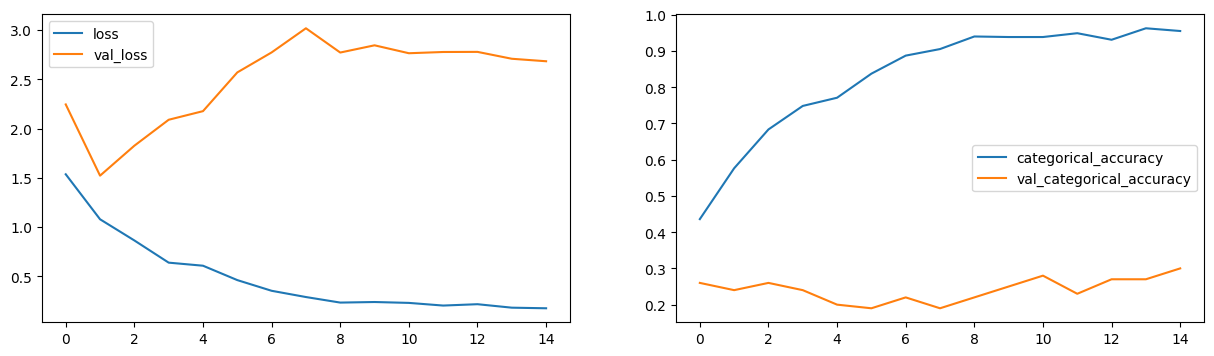

In [ ]:
plot(history_model_base1)

We can clearly see model is overfitting.

#### Model B - 3D Conv (100X100)

In [ ]:
class Conv3DModel_2(GenModel):
    
    def define_model(self,filtersize=(3,3,3),dense_neurons=64,dropout=0.25):

        model = Sequential()
        model.add(Conv3D(16, filtersize, padding='same',
                 input_shape=(self.frames_to_sample,self.image_height,self.image_width,self.channels)))
        model.add(Activation('relu'))
        model.add(BatchNormalization())
        model.add(MaxPooling3D(pool_size=(2, 2, 2)))

        model.add(Conv3D(32, filtersize, padding='same'))
        model.add(Activation('relu'))
        model.add(BatchNormalization())
        model.add(MaxPooling3D(pool_size=(2, 2, 2)))

        model.add(Conv3D(64, filtersize, padding='same'))
        model.add(Activation('relu'))
        model.add(BatchNormalization())
        model.add(MaxPooling3D(pool_size=(2, 2, 2)))

        model.add(Conv3D(128, filtersize, padding='same'))
        model.add(Activation('relu'))
        model.add(BatchNormalization())
        model.add(MaxPooling3D(pool_size=(2, 2, 2)))

        model.add(Flatten())
        model.add(Dense(dense_neurons,activation='relu'))
        model.add(BatchNormalization())
        model.add(Dropout(dropout))

        model.add(Dense(dense_neurons,activation='relu'))
        model.add(BatchNormalization())
        model.add(Dropout(dropout))


        model.add(Dense(self.num_classes,activation='softmax'))

        optimiser = tf.optimizers.Adam(lr=0.0002)
        model.compile(optimizer=optimiser, loss='categorical_crossentropy', metrics=['categorical_accuracy'])
        return model

In [ ]:
conv_3d_base2=Conv3DModel_2()
conv_3d_base2.initialize_path(project_folder)
conv_3d_base2.initialize_image_properties(image_height=100,image_width=100)
conv_3d_base2.initialize_hyperparams(frames_to_sample=16,batch_size=40,num_epochs=15)
conv_3d_model_base2=conv_3d_base2.define_model()
conv_3d_model_base2.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv3d (Conv3D)             (None, 16, 100, 100, 16)  1312      
                                                                 
 activation (Activation)     (None, 16, 100, 100, 16)  0         
                                                                 
 batch_normalization (BatchN  (None, 16, 100, 100, 16)  64       
 ormalization)                                                   
                                                                 
 max_pooling3d (MaxPooling3D  (None, 8, 50, 50, 16)    0         
 )                                                               
                                                                 
 conv3d_1 (Conv3D)           (None, 8, 50, 50, 32)     13856     
                                                                 
 activation_1 (Activation)   (None, 8, 50, 50, 32)     0

In [ ]:
print("Total Params:", conv_3d_model_base2.count_params())
history_model_base2 = conv_3d_base2.train_model(conv_3d_model_base2)

Total Params: 592773
Epoch 1/15
17/17 [==============================] - ETA: 0s - loss: 1.6854 - categorical_accuracy: 0.3906
Epoch 1: saving model to model_init_2023-06-0117_59_44.769665/model-00001-1.68541-0.39065-3.46943-0.23000.h5
17/17 [==============================] - 107s 6s/step - loss: 1.6854 - categorical_accuracy: 0.3906 - val_loss: 3.4694 - val_categorical_accuracy: 0.2300 - lr: 0.0010
Epoch 2/15
17/17 [==============================] - ETA: 0s - loss: 1.1956 - categorical_accuracy: 0.5490
Epoch 2: saving model to model_init_2023-06-0117_59_44.769665/model-00002-1.19556-0.54902-1.50805-0.23000.h5
17/17 [==============================] - 95s 6s/step - loss: 1.1956 - categorical_accuracy: 0.5490 - val_loss: 1.5080 - val_categorical_accuracy: 0.2300 - lr: 0.0010
Epoch 3/15
17/17 [==============================] - ETA: 0s - loss: 0.9611 - categorical_accuracy: 0.6305
Epoch 3: saving model to model_init_2023-06-0117_59_44.769665/model-00003-0.96113-0.63047-2.06513-0.23000.h5
1

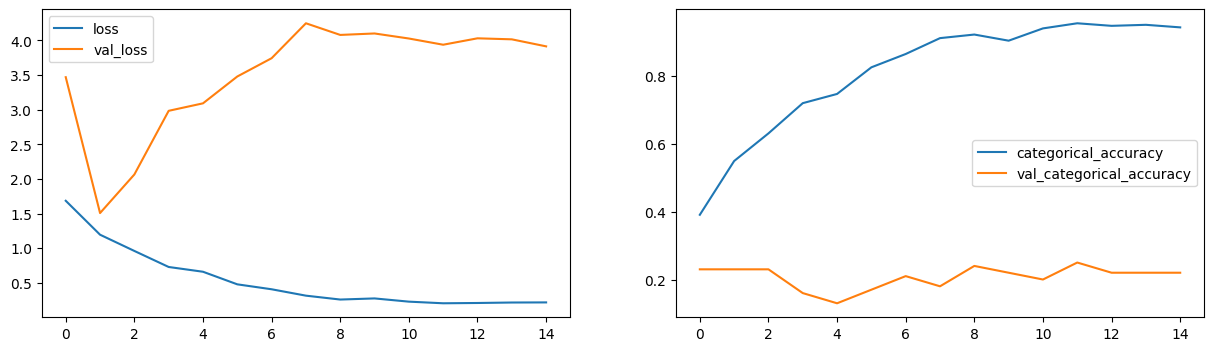

In [ ]:
plot(history_model_base2)

No significant improveement, still overfitting

#### Model C - 3D Conv (100X100), batchsize= 30, dense_neurons= 128

In [ ]:
class Conv3DModel_3(GenModel):
    
    def define_model(self,filtersize=(3,3,3),dense_neurons=128,dropout=0.25):

        model = Sequential()
        model.add(Conv3D(16, filtersize, padding='same',
                 input_shape=(self.frames_to_sample,self.image_height,self.image_width,self.channels)))
        model.add(Activation('relu'))
        model.add(BatchNormalization())
        model.add(MaxPooling3D(pool_size=(2, 2, 2)))

        model.add(Conv3D(32, filtersize, padding='same'))
        model.add(Activation('relu'))
        model.add(BatchNormalization())
        model.add(MaxPooling3D(pool_size=(2, 2, 2)))

        model.add(Conv3D(64, filtersize, padding='same'))
        model.add(Activation('relu'))
        model.add(BatchNormalization())
        model.add(MaxPooling3D(pool_size=(2, 2, 2)))

        model.add(Conv3D(128, filtersize, padding='same'))
        model.add(Activation('relu'))
        model.add(BatchNormalization())
        model.add(MaxPooling3D(pool_size=(2, 2, 2)))

        model.add(Flatten())
        model.add(Dense(dense_neurons,activation='relu'))
        model.add(BatchNormalization())
        model.add(Dropout(dropout))

        model.add(Dense(dense_neurons,activation='relu'))
        model.add(BatchNormalization())
        model.add(Dropout(dropout))


        model.add(Dense(self.num_classes,activation='softmax'))

        optimiser = tf.optimizers.Adam(lr=0.0002)
        model.compile(optimizer=optimiser, loss='categorical_crossentropy', metrics=['categorical_accuracy'])
        return model

In [ ]:
conv_3d_3=Conv3DModel_3()
conv_3d_3.initialize_path(project_folder)
conv_3d_3.initialize_image_properties(image_height=100,image_width=100)
conv_3d_3.initialize_hyperparams(frames_to_sample=16,batch_size=30,num_epochs=15)
conv_3d_model_3=conv_3d_3.define_model()
conv_3d_model_3.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv3d_8 (Conv3D)           (None, 16, 100, 100, 16)  1312      
                                                                 
 activation_8 (Activation)   (None, 16, 100, 100, 16)  0         
                                                                 
 batch_normalization_12 (Bat  (None, 16, 100, 100, 16)  64       
 chNormalization)                                                
                                                                 
 max_pooling3d_8 (MaxPooling  (None, 8, 50, 50, 16)    0         
 3D)                                                             
                                                                 
 conv3d_9 (Conv3D)           (None, 8, 50, 50, 32)     13856     
                                                                 
 activation_9 (Activation)   (None, 8, 50, 50, 32)    

In [ ]:
print("Total Params:", conv_3d_model_3.count_params())
history_model_3 = conv_3d_3.train_model(conv_3d_model_3)

Total Params: 900933
Epoch 1/15
23/23 [==============================] - ETA: 0s - loss: 1.6178 - categorical_accuracy: 0.3937
Epoch 1: saving model to model_init_2023-06-0116_27_35.800340/model-00001-1.61781-0.39367-1.74345-0.21000.h5
23/23 [==============================] - 89s 4s/step - loss: 1.6178 - categorical_accuracy: 0.3937 - val_loss: 1.7434 - val_categorical_accuracy: 0.2100 - lr: 0.0010
Epoch 2/15
23/23 [==============================] - ETA: 0s - loss: 1.1060 - categorical_accuracy: 0.5701
Epoch 2: saving model to model_init_2023-06-0116_27_35.800340/model-00002-1.10600-0.57014-3.39091-0.22000.h5
23/23 [==============================] - 89s 4s/step - loss: 1.1060 - categorical_accuracy: 0.5701 - val_loss: 3.3909 - val_categorical_accuracy: 0.2200 - lr: 0.0010
Epoch 3/15
23/23 [==============================] - ETA: 0s - loss: 0.8998 - categorical_accuracy: 0.6531
Epoch 3: saving model to model_init_2023-06-0116_27_35.800340/model-00003-0.89976-0.65309-3.98497-0.20000.h5
23

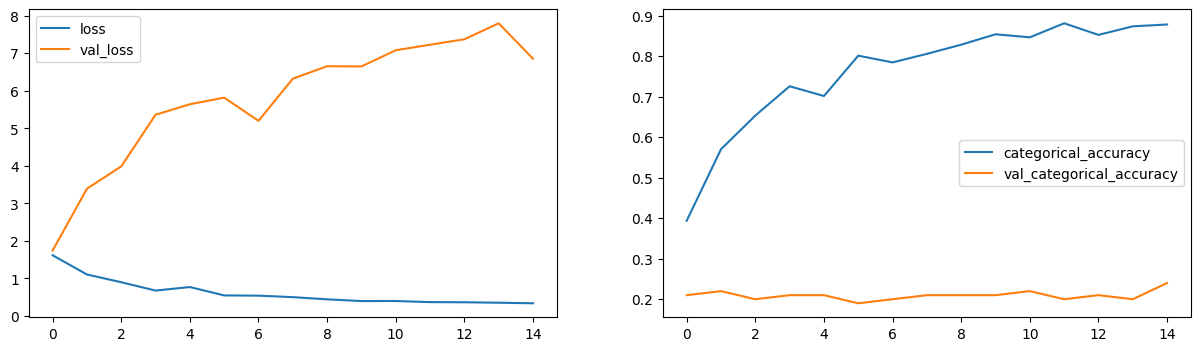

In [ ]:
plot(history_model_3)

still no improvement , overfittinig exits

#### Model D - CNN- LSTM Model

In [ ]:
class RNNCNN1(GenModel):
    
    def define_model(self,lstm_cells=64,dense_neurons=64,dropout=0.25):

        model = Sequential()

        model.add(TimeDistributed(Conv2D(16, (3, 3) , padding='same', activation='relu'),
                                  input_shape=(self.frames_to_sample,self.image_height,self.image_width,self.channels)))
        model.add(TimeDistributed(BatchNormalization()))
        model.add(TimeDistributed(MaxPooling2D((2, 2))))
        
        model.add(TimeDistributed(Conv2D(32, (3, 3) , padding='same', activation='relu')))
        model.add(TimeDistributed(BatchNormalization()))
        model.add(TimeDistributed(MaxPooling2D((2, 2))))
        
        model.add(TimeDistributed(Conv2D(64, (3, 3) , padding='same', activation='relu')))
        model.add(TimeDistributed(BatchNormalization()))
        model.add(TimeDistributed(MaxPooling2D((2, 2))))
        
        model.add(TimeDistributed(Conv2D(128, (3, 3) , padding='same', activation='relu')))
        model.add(TimeDistributed(BatchNormalization()))
        model.add(TimeDistributed(MaxPooling2D((2, 2))))
        
        model.add(TimeDistributed(Conv2D(256, (3, 3) , padding='same', activation='relu')))
        model.add(TimeDistributed(BatchNormalization()))
        model.add(TimeDistributed(MaxPooling2D((2, 2))))
        
        #model.add(TimeDistributed(Conv2D(512, (2, 2) , padding='valid', activation='relu')))
       # model.add(TimeDistributed(BatchNormalization()))
       # model.add(TimeDistributed(MaxPooling2D((2, 2))))

        model.add(TimeDistributed(Flatten()))


        model.add(LSTM(lstm_cells))
        model.add(Dropout(dropout))
        
        model.add(Dense(dense_neurons,activation='relu'))
        model.add(Dropout(dropout))
        
        model.add(Dense(self.num_classes, activation='softmax'))
        optimiser = tf.optimizers.Adam()
        model.compile(optimizer=optimiser, loss='categorical_crossentropy', metrics=['categorical_accuracy'])
        return model

In [ ]:
rnn_cnn_1=RNNCNN1()
rnn_cnn_1.initialize_path(project_folder)
rnn_cnn_1.initialize_image_properties(image_height=120,image_width=120)
rnn_cnn_1.initialize_hyperparams(frames_to_sample=18,batch_size=20,num_epochs=20)
rnn_cnn_model_1=rnn_cnn_1.define_model(lstm_cells=128,dense_neurons=128,dropout=0.25)
rnn_cnn_model_1.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 time_distributed_32 (TimeDi  (None, 18, 120, 120, 16)  448      
 stributed)                                                      
                                                                 
 time_distributed_33 (TimeDi  (None, 18, 120, 120, 16)  64       
 stributed)                                                      
                                                                 
 time_distributed_34 (TimeDi  (None, 18, 60, 60, 16)   0         
 stributed)                                                      
                                                                 
 time_distributed_35 (TimeDi  (None, 18, 60, 60, 32)   4640      
 stributed)                                                      
                                                                 
 time_distributed_36 (TimeDi  (None, 18, 60, 60, 32)  

In [ ]:
print("Total Params:", rnn_cnn_model_1.count_params())
history_model_4=rnn_cnn_1.train_model(rnn_cnn_model_1, augment_data=False)

Total Params: 1657445
Epoch 1/20
34/34 [==============================] - ETA: 0s - loss: 1.4139 - categorical_accuracy: 0.3710
Epoch 1: saving model to model_init_2023-06-0217_40_45.305173/model-00001-1.41387-0.37104-1.82376-0.21000.h5
34/34 [==============================] - 126s 3s/step - loss: 1.4139 - categorical_accuracy: 0.3710 - val_loss: 1.8238 - val_categorical_accuracy: 0.2100 - lr: 0.0010
Epoch 2/20
34/34 [==============================] - ETA: 0s - loss: 1.1402 - categorical_accuracy: 0.5158
Epoch 2: saving model to model_init_2023-06-0217_40_45.305173/model-00002-1.14024-0.51584-1.92892-0.16000.h5
34/34 [==============================] - 114s 3s/step - loss: 1.1402 - categorical_accuracy: 0.5158 - val_loss: 1.9289 - val_categorical_accuracy: 0.1600 - lr: 0.0010
Epoch 3/20
34/34 [==============================] - ETA: 0s - loss: 1.0726 - categorical_accuracy: 0.5626
Epoch 3: saving model to model_init_2023-06-0217_40_45.305173/model-00003-1.07265-0.56259-2.09590-0.24000.h5

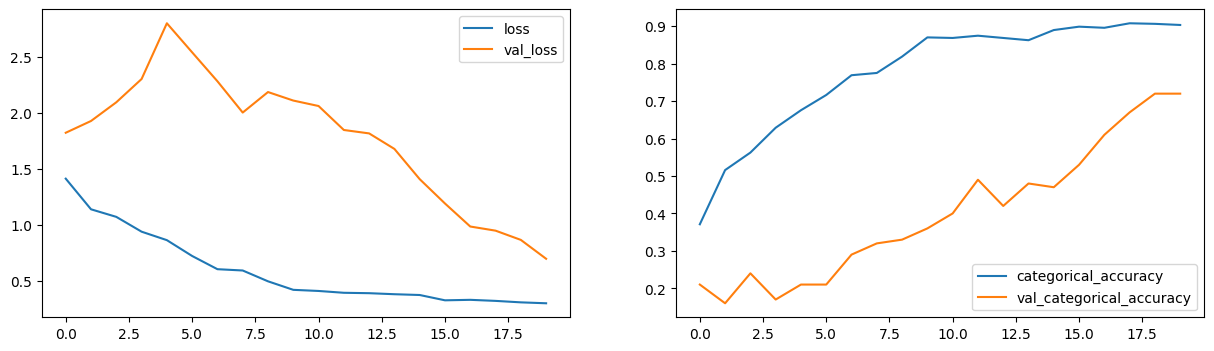

In [ ]:
plot(history_model_4)

Model is performing better with decrease in loss for both train and validation. Also accuracy of val has increased.

#### Model E - CNN- GRU Model

In [13]:
class RNNCNN2(GenModel):
    
    def define_model(self,lstm_cells=64,dense_neurons=64,dropout=0.25):

        model = Sequential()

        model.add(TimeDistributed(Conv2D(16, (3, 3) , padding='same', activation='relu'),
                                  input_shape=(self.frames_to_sample,self.image_height,self.image_width,self.channels)))
        model.add(TimeDistributed(BatchNormalization()))
        model.add(TimeDistributed(MaxPooling2D((2, 2))))
        
        model.add(TimeDistributed(Conv2D(32, (3, 3) , padding='same', activation='relu')))
        model.add(TimeDistributed(BatchNormalization()))
        model.add(TimeDistributed(MaxPooling2D((2, 2))))
        
        model.add(TimeDistributed(Conv2D(64, (3, 3) , padding='same', activation='relu')))
        model.add(TimeDistributed(BatchNormalization()))
        model.add(TimeDistributed(MaxPooling2D((2, 2))))
        
        model.add(TimeDistributed(Conv2D(128, (3, 3) , padding='same', activation='relu')))
        model.add(TimeDistributed(BatchNormalization()))
        model.add(TimeDistributed(MaxPooling2D((2, 2))))
        

        model.add(TimeDistributed(Flatten()))


        model.add(GRU(lstm_cells))
        model.add(Dropout(dropout))
        
        model.add(Dense(dense_neurons,activation='relu'))
        model.add(Dropout(dropout))
        
        model.add(Dense(self.num_classes, activation='softmax'))
        optimiser = tf.optimizers.Adam(lr=0.0002)
        model.compile(optimizer=optimiser, loss='categorical_crossentropy', metrics=['categorical_accuracy'])
        return model

In [14]:
rnn_cnn2=RNNCNN2()
rnn_cnn2.initialize_path(project_folder)
rnn_cnn2.initialize_image_properties(image_height=120,image_width=120)
rnn_cnn2.initialize_hyperparams(frames_to_sample=18,batch_size=20,num_epochs=20)
rnn_cnn2_model=rnn_cnn2.define_model(lstm_cells=128,dense_neurons=128,dropout=0.25)
rnn_cnn2_model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 time_distributed_4 (TimeDis  (None, 18, 120, 120, 16)  448      
 tributed)                                                       
                                                                 
 time_distributed_5 (TimeDis  (None, 18, 120, 120, 16)  64       
 tributed)                                                       
                                                                 
 time_distributed_6 (TimeDis  (None, 18, 60, 60, 16)   0         
 tributed)                                                       
                                                                 
 time_distributed_7 (TimeDis  (None, 18, 60, 60, 32)   4640      
 tributed)                                                       
                                                                 
 time_distributed_8 (TimeDis  (None, 18, 60, 60, 32)  

In [15]:
print("Total Params:", rnn_cnn2_model.count_params())
history_model5=rnn_cnn2.train_model(rnn_cnn2_model,augment_data=True)

Total Params: 2573925
Epoch 1/20
34/34 [==============================] - ETA: 0s - loss: 1.4789 - categorical_accuracy: 0.3741
Epoch 1: saving model to model_init_2023-06-0411_30_56.700391/model-00001-1.47888-0.37406-1.95210-0.16000.h5
34/34 [==============================] - 203s 6s/step - loss: 1.4789 - categorical_accuracy: 0.3741 - val_loss: 1.9521 - val_categorical_accuracy: 0.1600 - lr: 0.0010
Epoch 2/20
34/34 [==============================] - ETA: 0s - loss: 1.1074 - categorical_accuracy: 0.5513
Epoch 2: saving model to model_init_2023-06-0411_30_56.700391/model-00002-1.10741-0.55128-1.85755-0.17000.h5
34/34 [==============================] - 192s 6s/step - loss: 1.1074 - categorical_accuracy: 0.5513 - val_loss: 1.8575 - val_categorical_accuracy: 0.1700 - lr: 0.0010
Epoch 3/20
34/34 [==============================] - ETA: 0s - loss: 0.9225 - categorical_accuracy: 0.6350
Epoch 3: saving model to model_init_2023-06-0411_30_56.700391/model-00003-0.92255-0.63499-1.85021-0.12000.h5

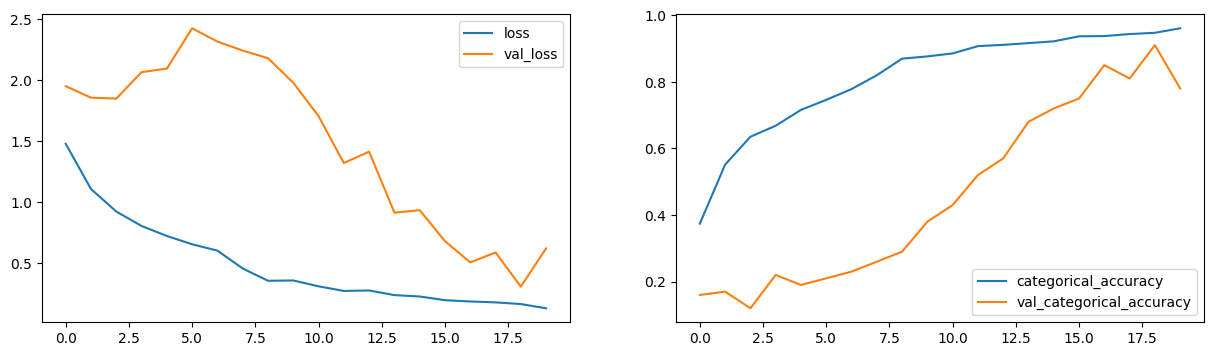

In [16]:
plot(history_model5)

We are getting further improvement in accuracy compared to LSTM

#### Model F - Use of Transfer Learning and LSTM

In [8]:
from keras.applications import mobilenet

In [9]:
mobilenet_transfer = mobilenet.MobileNet(weights='imagenet', include_top=False)

class RNNCNN_TL(GenModel):
    
    def define_model(self,lstm_cells=64,dense_neurons=64,dropout=0.25):
        
        model = Sequential()
        model.add(TimeDistributed(mobilenet_transfer,input_shape=(self.frames_to_sample,self.image_height,self.image_width,self.channels)))
        
        
        for layer in model.layers:
            layer.trainable = False
        
        
        model.add(TimeDistributed(BatchNormalization()))
        model.add(TimeDistributed(MaxPooling2D((2, 2))))
        model.add(TimeDistributed(Flatten()))

        model.add(LSTM(lstm_cells))
        model.add(Dropout(dropout))
        
        model.add(Dense(dense_neurons,activation='relu'))
        model.add(Dropout(dropout))
        
        model.add(Dense(self.num_classes, activation='softmax'))
        
        
        optimiser = tf.optimizers.Adam()
        model.compile(optimizer=optimiser, loss='categorical_crossentropy', metrics=['categorical_accuracy'])
        return model

17225924/17225924 [==============================] - 2s 0us/step


In [10]:
rnn_cnn_t_l=RNNCNN_TL()
rnn_cnn_t_l.initialize_path(project_folder)
rnn_cnn_t_l.initialize_image_properties(image_height=120,image_width=120)
rnn_cnn_t_l.initialize_hyperparams(frames_to_sample=16,batch_size=5,num_epochs=20)
rnn_cnn_t_model_1=rnn_cnn_t_l.define_model(lstm_cells=128,dense_neurons=128,dropout=0.25)
rnn_cnn_t_model_1.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 time_distributed (TimeDistr  (None, 16, 3, 3, 1024)   3228864   
 ibuted)                                                         
                                                                 
 time_distributed_1 (TimeDis  (None, 16, 3, 3, 1024)   4096      
 tributed)                                                       
                                                                 
 time_distributed_2 (TimeDis  (None, 16, 1, 1, 1024)   0         
 tributed)                                                       
                                                                 
 time_distributed_3 (TimeDis  (None, 16, 1024)         0         
 tributed)                                                       
                                                                 
 lstm (LSTM)                 (None, 128)               5

In [11]:
print("Total Params:", rnn_cnn_t_model_1.count_params())
history_model_6=rnn_cnn_t_l.train_model(rnn_cnn_t_model_1,augment_data=False)

Total Params: 3840453
Epoch 1/20
133/133 [==============================] - ETA: 0s - loss: 1.3942 - categorical_accuracy: 0.4057
Epoch 1: saving model to model_init_2023-06-0410_56_29.386880/model-00001-1.39418-0.40573-1.00734-0.69000.h5
133/133 [==============================] - 111s 728ms/step - loss: 1.3942 - categorical_accuracy: 0.4057 - val_loss: 1.0073 - val_categorical_accuracy: 0.6900 - lr: 0.0010
Epoch 2/20
133/133 [==============================] - ETA: 0s - loss: 0.8491 - categorical_accuracy: 0.6757
Epoch 2: saving model to model_init_2023-06-0410_56_29.386880/model-00002-0.84908-0.67572-0.82968-0.67000.h5
133/133 [==============================] - 96s 726ms/step - loss: 0.8491 - categorical_accuracy: 0.6757 - val_loss: 0.8297 - val_categorical_accuracy: 0.6700 - lr: 0.0010
Epoch 3/20
133/133 [==============================] - ETA: 0s - loss: 0.6096 - categorical_accuracy: 0.7919
Epoch 3: saving model to model_init_2023-06-0410_56_29.386880/model-00003-0.60959-0.79186-0.8

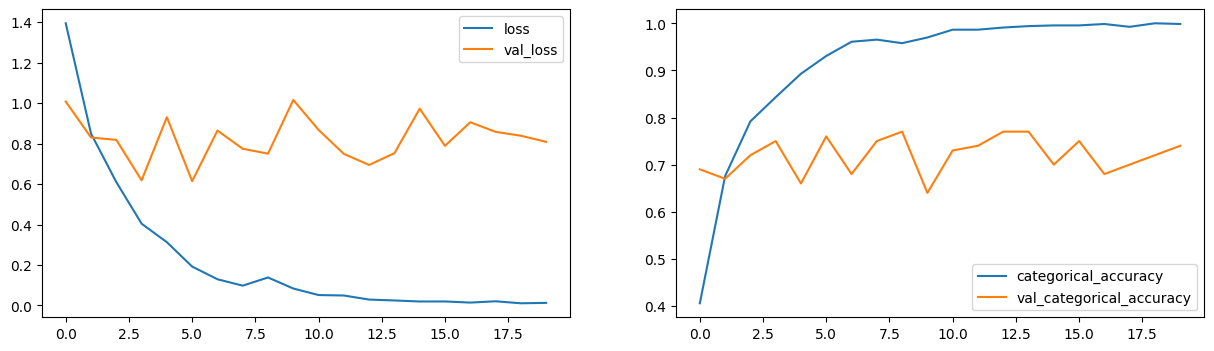

In [12]:
plot(history_model_6)

The loss of training has reduced compared to LSTM model , but validation loss has increased.

#### Model G: Transfer Learning with GRU 

In [ ]:
from keras.applications import mobilenet

mobilenet_transfer = mobilenet.MobileNet(weights='imagenet', include_top=False)

class RNNCNN_TL2(GenModel):
    
    def define_model(self,gru_cells=64,dense_neurons=64,dropout=0.25):
        
        model = Sequential()
        model.add(TimeDistributed(mobilenet_transfer,input_shape=(self.frames_to_sample,self.image_height,self.image_width,self.channels)))
 
        
        model.add(TimeDistributed(BatchNormalization()))
        model.add(TimeDistributed(MaxPooling2D((2, 2))))
        model.add(TimeDistributed(Flatten()))

        model.add(GRU(gru_cells))
        model.add(Dropout(dropout))
        
        model.add(Dense(dense_neurons,activation='relu'))
        model.add(Dropout(dropout))
        
        model.add(Dense(self.num_classes, activation='softmax'))
        
        
        optimiser = tf.optimizers.Adam()
        model.compile(optimizer=optimiser, loss='categorical_crossentropy', metrics=['categorical_accuracy'])
        return model

17225924/17225924 [==============================] - 2s 0us/step


In [ ]:
rnn_cnn_tl_2=RNNCNN_TL2()
rnn_cnn_tl_2.initialize_path(project_folder)
rnn_cnn_tl_2.initialize_image_properties(image_height=120,image_width=120)
rnn_cnn_tl_2.initialize_hyperparams(frames_to_sample=18,batch_size=20,num_epochs=20)
rnn_cnn_tl_model_2=rnn_cnn_tl_2.define_model(gru_cells=128,dense_neurons=128,dropout=0.25)
rnn_cnn_tl_model_2.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 time_distributed_4 (TimeDis  (None, 18, 3, 3, 1024)   3228864   
 tributed)                                                       
                                                                 
 time_distributed_5 (TimeDis  (None, 18, 3, 3, 1024)   4096      
 tributed)                                                       
                                                                 
 time_distributed_6 (TimeDis  (None, 18, 1, 1, 1024)   0         
 tributed)                                                       
                                                                 
 time_distributed_7 (TimeDis  (None, 18, 1024)         0         
 tributed)                                                       
                                                                 
 gru_1 (GRU)                 (None, 128)              

In [ ]:
print("Total Params:", rnn_cnn_tl_model_2.count_params())
history_model7=rnn_cnn_tl_2.train_model(rnn_cnn_tl_model_2,augment_data=False)

Total Params: 3693253
Epoch 1/20
34/34 [==============================] - ETA: 0s - loss: 1.0666 - categorical_accuracy: 0.5686
Epoch 1: saving model to model_init_2023-06-0306_22_33.968020/model-00001-1.06664-0.56863-0.90396-0.69000.h5
34/34 [==============================] - 143s 3s/step - loss: 1.0666 - categorical_accuracy: 0.5686 - val_loss: 0.9040 - val_categorical_accuracy: 0.6900 - lr: 0.0010
Epoch 2/20
34/34 [==============================] - ETA: 0s - loss: 0.4604 - categorical_accuracy: 0.8175
Epoch 2: saving model to model_init_2023-06-0306_22_33.968020/model-00002-0.46037-0.81750-0.70119-0.72000.h5
34/34 [==============================] - 111s 3s/step - loss: 0.4604 - categorical_accuracy: 0.8175 - val_loss: 0.7012 - val_categorical_accuracy: 0.7200 - lr: 0.0010
Epoch 3/20
34/34 [==============================] - ETA: 0s - loss: 0.2455 - categorical_accuracy: 0.9155
Epoch 3: saving model to model_init_2023-06-0306_22_33.968020/model-00003-0.24548-0.91554-0.68737-0.75000.h5

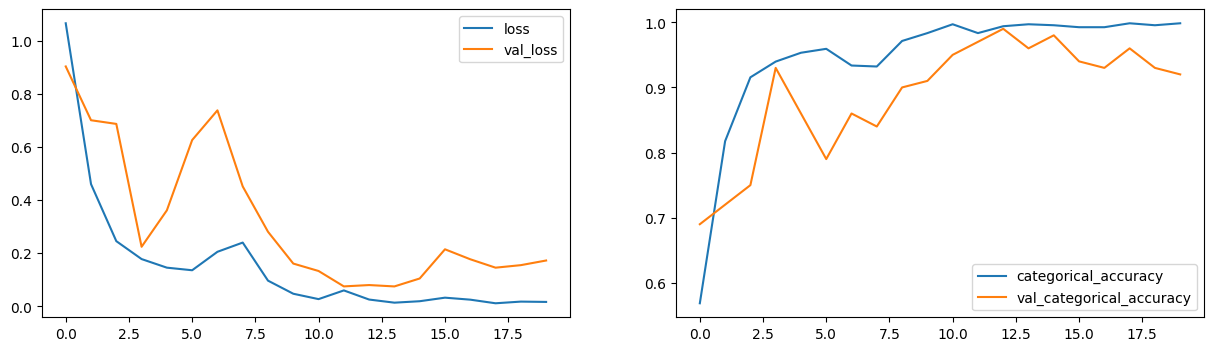

In [ ]:
plot(history_model7)

### Here we achieved a good training accuracy of 99.40%  and the validation accuracy of 99.0% in the 13th epoch.
- Trainable params: 3,669,317
- Non-trainable params: 23,936


### Finally, We found the best model!!!